Since production data is annual, **start out** by making annual predictions

Also, see what happens when including pre-quota data (with ending stocks)

In [1]:
from capstone_modules import Production_Data, Temperature_Data, ICO_Composite_Indicator

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Import data

In [2]:
master_dataframe = pd.DataFrame()

# Import production data
production = Production_Data()
ICO_categories = production.ICO_categories
for category in ICO_categories:
    temp_df = production.get_aggregate_production_data_by_ICO_category(category)
    temp_df.name = category + " Production (60 kg bags)"
    master_dataframe = pd.concat([master_dataframe, temp_df], axis = 1)

# Import ICO composite indicator index data
ICO_composite_indicator = ICO_Composite_Indicator().ICO_indicator_data[["ICO Composite Indicator"]]
    
# Import temperature data
temperature = Temperature_Data()

# Convert master_dataframe to a time series

master_dataframe.index = pd.to_datetime(master_dataframe.index, format = "%Y").values
master_dataframe = master_dataframe.resample("M").bfill()

master_dataframe = ICO_composite_indicator.merge(master_dataframe, left_index = True, right_index = True)

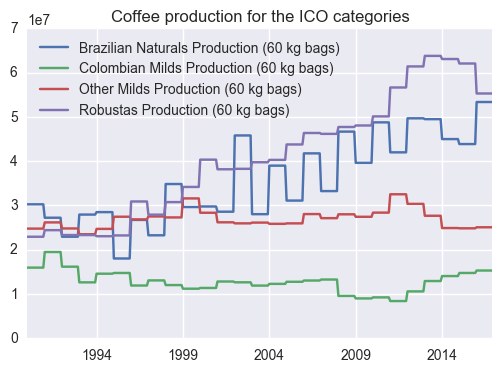

In [3]:
master_dataframe.drop("ICO Composite Indicator", axis = 1).plot()
plt.title("Coffee production for the ICO categories")
plt.show()

In [4]:
production_shares_by_type = production.get_production_share_by_country()[production.get_production_share_by_country()["Market_Year"] > 1989].pivot_table(values = ["Arabica Production Share", "Robusta Production Share"], index = ["Country"])


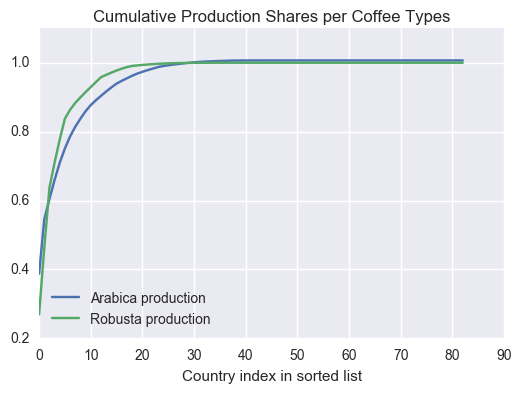

In [5]:
plt.plot(np.cumsum(production_shares_by_type.sort_values("Arabica Production Share", ascending = False)["Arabica Production Share"].values))
plt.plot(np.cumsum(production_shares_by_type.sort_values("Robusta Production Share", ascending = False)["Robusta Production Share"].values))
plt.title("Cumulative Production Shares per Coffee Types")
plt.legend(["Arabica production", "Robusta production"], loc = 'best')
plt.xlabel("Country index in sorted list")
plt.show()


This means we can achieve good accuracy if we look at only the top 5-10 countries.

In [6]:
main_arabica_producers = production_shares_by_type.sort_values("Arabica Production Share", ascending = False)["Arabica Production Share"].head(5).index.values
main_robusta_producers = production_shares_by_type.sort_values("Robusta Production Share", ascending = False)["Robusta Production Share"].head(5).index.values


In [7]:
set().union(main_arabica_producers, main_robusta_producers)

{'Brazil',
 'Colombia',
 "Cote d'Ivoire",
 'Ethiopia',
 'Guatemala',
 'Indonesia',
 'Mexico',
 'Uganda',
 'Vietnam'}

### Try predicting ICO composite indicator values from previous year's production values

In [8]:
def simple_linear_model_with_previous_production(dataframe, show_actual_vs_predicted = False):
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-1]
    y = dataframe["ICO Composite Indicator"].iloc[1:]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)
    
    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
        
    train_y.plot()
    plt.scatter(x = test_y.index, y = linear_model.predict(test_X), c ="r")
    plt.title("Linear Regression Model")
    plt.show()

    print("Linear model score: {}".format(linear_model.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(linear_model, X, y, cv = 10).mean()))

    if show_actual_vs_predicted == True:
        plt.scatter(linear_model.predict(test_X), test_y)
        plt.xlabel("Predicted ICO composite indicator values")
        plt.ylabel("Actual ICO composite indicator values")
        plt.title("Modeling ICO composite indicator from categories")
        plt.show()   
        
def random_forest_model_with_previous_production(dataframe, show_actual_vs_predicted = False):
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-1]
    y = dataframe["ICO Composite Indicator"].iloc[1:]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)

    random_forest_reg = RandomForestRegressor(n_estimators = 100)
    random_forest_reg.fit(train_X, train_y)

    train_y.plot()
    plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score: {}".format(random_forest_reg.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(random_forest_reg, X, y, cv = 10).mean()))

    pd.DataFrame(data = random_forest_reg.feature_importances_, 
             index = dataframe.dropna(thresh = (dataframe.shape[0] - 2), 
                                           axis = 'columns').columns[1:]).plot.barh()
    plt.title("Feature importance")
    plt.show()
    
    if show_actual_vs_predicted == True:
        plt.scatter(random_forest_reg.predict(test_X), test_y)
        plt.xlabel("Predicted ICO composite indicator values")
        plt.ylabel("Actual ICO composite indicator values")
        plt.title("Modeling ICO composite indicator from categories")
        plt.show()   


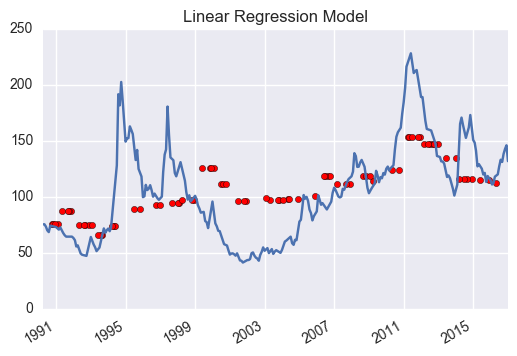

Linear model score: 0.30299833515136965
Average cross validation score (MSE): 24.511184025424647


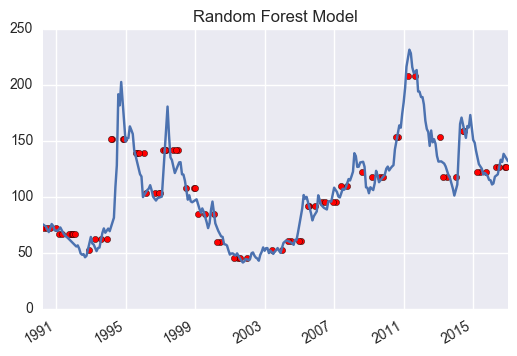

Random forest model score: 0.8957417862566632
Average cross validation score (MSE): 7.984453353234071


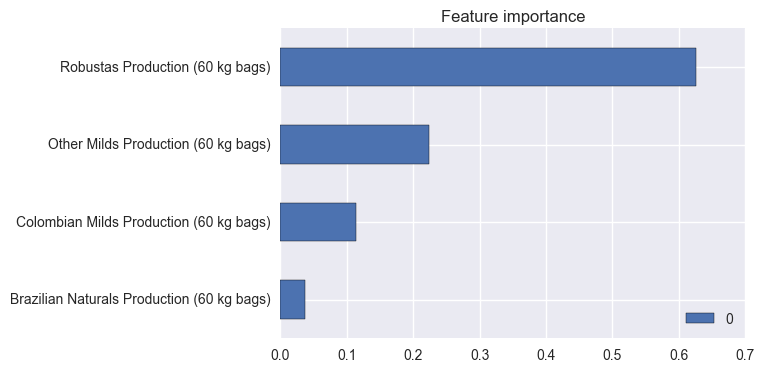

In [9]:
simple_linear_model_with_previous_production(master_dataframe[1:])
random_forest_model_with_previous_production(master_dataframe[1:])

## Adding additional features to the Master DataFrame

In [10]:
test_dataframe = master_dataframe.copy()
for category in production.ICO_categories:
    for country in set().union(main_arabica_producers, main_robusta_producers):
        temp_production_df = production.get_ending_stocks_by_ICO_category(category)[production.get_ending_stocks_by_ICO_category(category)["Country"] == country][["Market_Year","Percent Change"]]
        temp_production_df["Percent Change"] = temp_production_df["Percent Change"].replace(np.inf, np.NaN)
        temp_production_df.columns = ["Market_Year", country + " Ending Stock Percent Change, " + category]
        
        temp_frost_risk_df = temperature.get_temperature_data_by_country(country)[["Frost likelihood"]].resample("M").max()
        temp_frost_risk_df = temp_frost_risk_df[temp_frost_risk_df.index.year >= 1990]
        temp_frost_risk_df.columns = [country + " frost likelihood"]
        
        temp_production_df.index = pd.to_datetime(temp_production_df["Market_Year"].values, format = "%Y")
        temp_production_df = temp_production_df.drop("Market_Year", axis = 'columns')
        temp_production_df = temp_production_df.resample("M").bfill()
        
        temp_production_df = temp_production_df.merge(temp_frost_risk_df, left_index = True, right_index = True)#, left_on = "Market_Year", right_on = "Year", copy = False)
        
        test_dataframe = pd.concat([test_dataframe, temp_production_df], axis = 1)
        
test_dataframe = test_dataframe.dropna(axis = 'columns', thresh = test_dataframe.shape[0] - 1)
test_dataframe = test_dataframe.T.drop_duplicates().T
# test_dataframe = test_dataframe.fillna(method = "bfill")



//anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


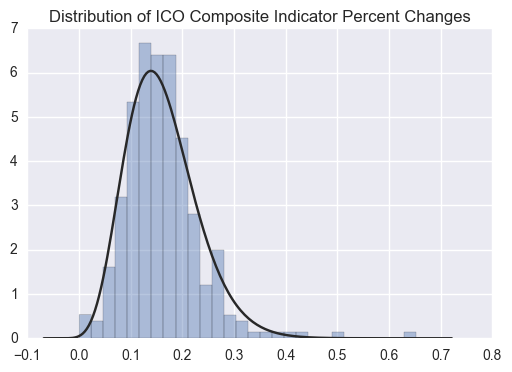

,ICO Composite Indicator
count,322.000000
mean,0.004540
std,0.072377
min,-0.156115
25%,-0.041048
50%,-0.004142
75%,0.039029
max,0.496677


In [11]:
# The percent changes follow a beta distribution

from scipy.stats import beta

ICO_composite_indicator_percent_changes = test_dataframe.ix[1:, "ICO Composite Indicator"].to_frame().pct_change().dropna()
# a, b, loc, scale = beta.fit(ICO_composite_indicator_percent_changes - ICO_composite_indicator_percent_changes.values.min())

sns.distplot(ICO_composite_indicator_percent_changes.values - ICO_composite_indicator_percent_changes.values.min(), fit = beta, kde = False)
plt.title("Distribution of ICO Composite Indicator Percent Changes")
plt.show()

test_dataframe.ix[1:, "ICO Composite Indicator"].to_frame().pct_change().dropna().describe()


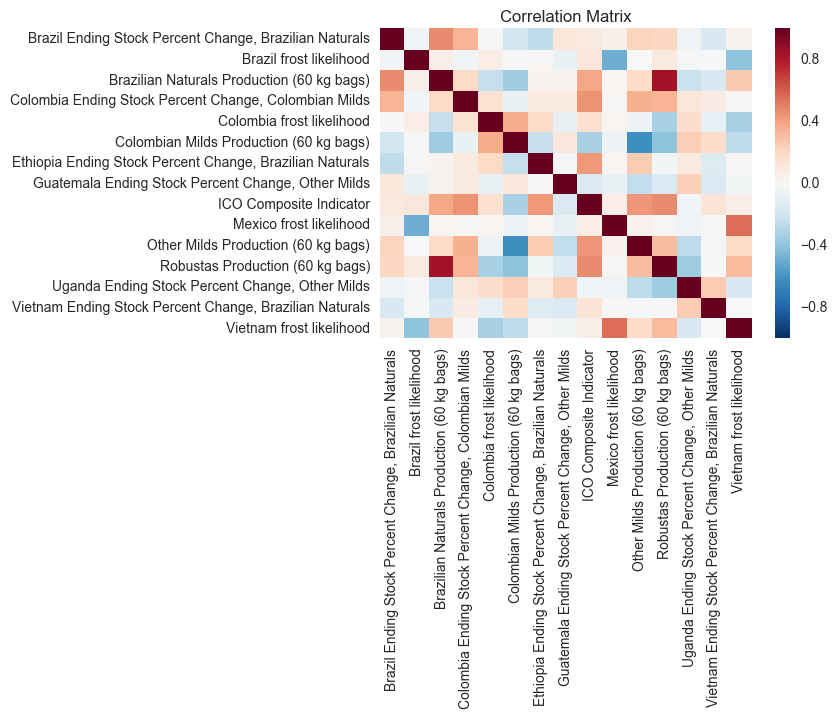

In [12]:
sns.heatmap(test_dataframe.T.drop_duplicates().sort_index().T.corr())
plt.title("Correlation Matrix")
plt.show()


# Checking if PCA would help

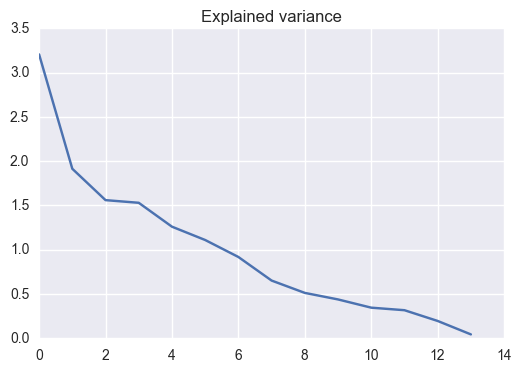

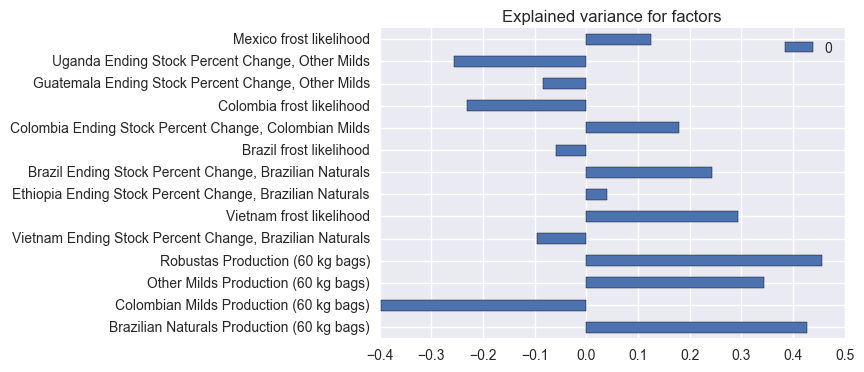

In [13]:
from sklearn.pipeline import Pipeline

pca = PCA()
scaler = StandardScaler()

pca_test_dataframe = test_dataframe[test_dataframe.index.year < 2017].drop("ICO Composite Indicator", axis = 1)
pipe = Pipeline(steps = [("scaler", scaler), ('pca', pca)])

pipe.fit_transform(pca_test_dataframe)

plt.plot(pca.explained_variance_)
plt.title("Explained variance")
plt.show()

pd.DataFrame(pca.components_[0], index = test_dataframe.drop("ICO Composite Indicator", axis = 1).columns).plot(kind = 'barh')
plt.title("Explained variance for factors")
plt.show()

# Clearly PCA wouldn't help


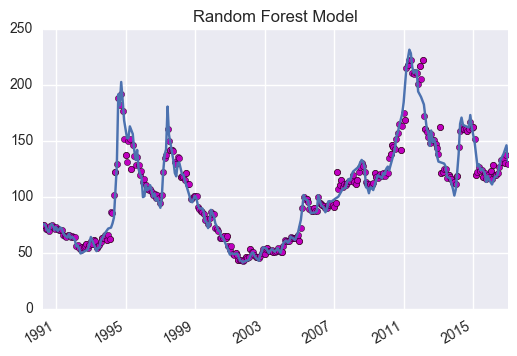

Random forest model score (R-squared): 0.9680121909583976
Average cross validation score (MSE): 10.80348928192375


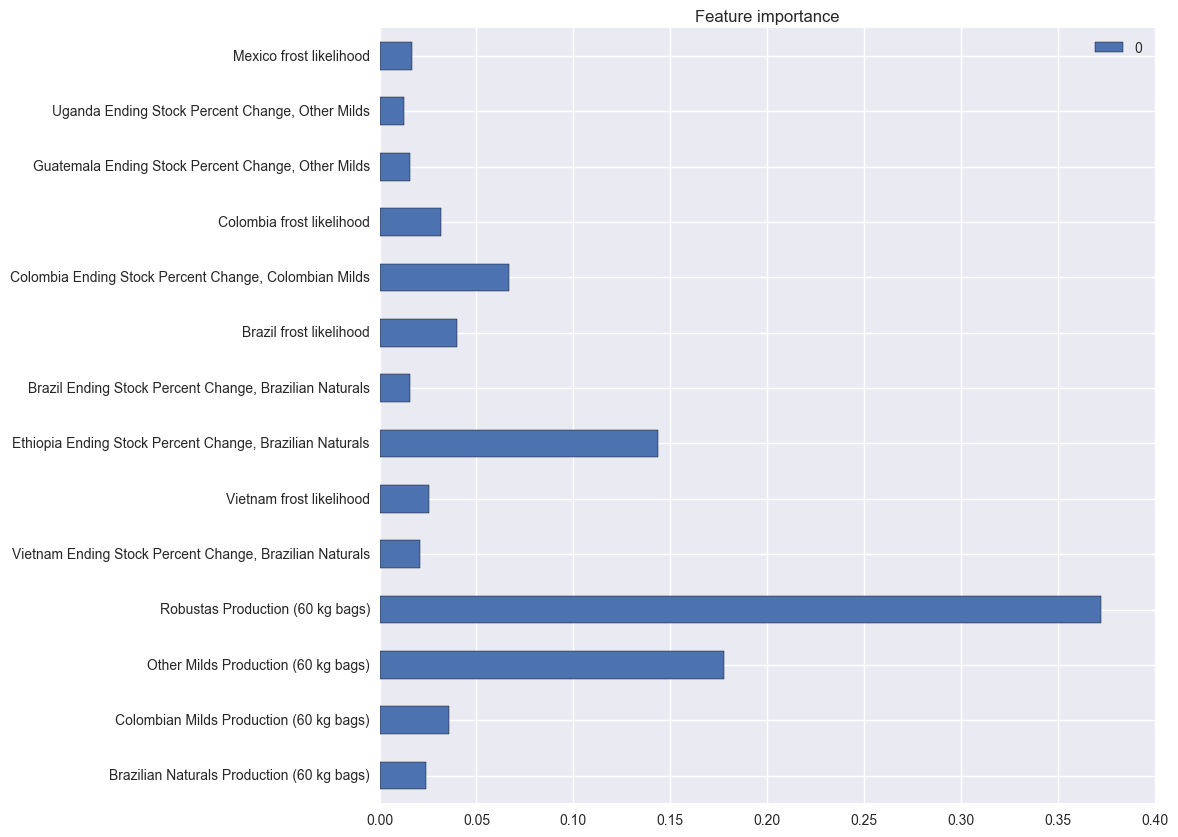

In [14]:
def random_forest_model_with_previous_production_and_ending_stocks(dataframe):
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-1]
    y = dataframe.ix[1:, "ICO Composite Indicator"]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)

    random_forest_reg = RandomForestRegressor(n_estimators = 100)
    random_forest_reg.fit(train_X, train_y)

    train_y.plot()
    plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
    plt.scatter(x = y.index, y = random_forest_reg.predict(X), c ="m")
    plt.title("Random Forest Model")
    plt.show()
    
    
    print("Random forest model score (R-squared): {}".format(random_forest_reg.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(random_forest_reg, X, y, cv = 10).mean()))

    pd.DataFrame(data = random_forest_reg.feature_importances_, 
             index = test_dataframe.columns[1:]).plot.barh(figsize=(10,10))
    plt.title("Feature importance")
    plt.show()
    
    
    return random_forest_reg
    
random_forest_reg = random_forest_model_with_previous_production_and_ending_stocks(test_dataframe[test_dataframe.index.year < 2017][1:])


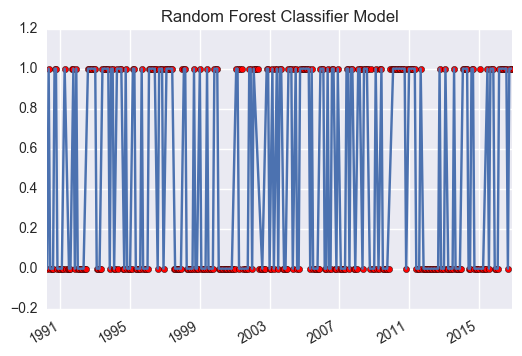

Baseline predictor: 0.4751552795031056
Random forest classifier model score: 0.8757763975155279
Average cross validation score (MSE): -0.42146871945259046


In [15]:
def random_forest_classifier_with_previous_production_and_ending_stocks(dataframe, show_actual_vs_predicted = False):
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-1]
    y = dataframe.ix[1:, "ICO Composite Indicator"]
    
    y_increase = y.to_frame().pct_change() > 0
    y_increase.columns = ["Positive percent change"]
    y_increase = y_increase["Positive percent change"].map({True: 1, False: 0})
    
    train_X, test_X, train_y, test_y = train_test_split(X, y_increase)

    random_forest_classifier = RandomForestClassifier(n_estimators = 100)
    random_forest_classifier.fit(train_X, train_y)

    train_y.plot()
    plt.scatter(x = y_increase.index, y = random_forest_classifier.predict(X), c ="r")
    plt.title("Random Forest Classifier Model")
    plt.show()
    
    print("Baseline predictor: {}".format(y_increase.mean()))
    print("Random forest classifier model score: {}".format(random_forest_classifier.score(X, y_increase)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(random_forest_classifier, X, y_increase, cv = 10).mean()))
    
    return random_forest_classifier
        
random_forest_classifier = random_forest_classifier_with_previous_production_and_ending_stocks(test_dataframe[test_dataframe.index.year < 2017][1:])


# Random forest models with GridSearch

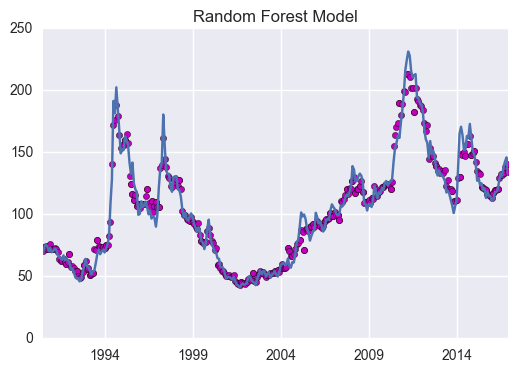

Random forest model score (pre-GridSearch): 0.971697700729838
Average cross validation score (MSE, pre-GridSearch): 14.480562765147393


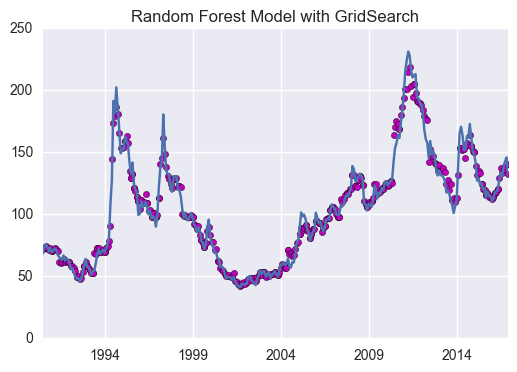

Random forest model score (with GridSearch): 0.9827452116634847


In [16]:
def optimized_random_forest_regression_model(dataframe, show_all_predictions = False):
    months_offset = 5
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-months_offset]
    y = dataframe.ix[months_offset:, "ICO Composite Indicator"]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)
    
    random_forest_reg = RandomForestRegressor(n_estimators = 200, max_features = "sqrt")
    random_forest_reg.fit(train_X, train_y)

    y.plot()
    plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
    if show_all_predictions == True:
        plt.scatter(x = y.index, y = random_forest_reg.predict(X), c ="m")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score (pre-GridSearch): {}".format(random_forest_reg.score(X, y)))
    print("Average cross validation score (MSE, pre-GridSearch): {}".format(- cross_val_score(random_forest_reg, X, y, cv = 10).mean()))

    param_grid_for_gridsearch = {"criterion": ["mse", "mae"], 
                                 "max_features": ["auto", "sqrt", "log2"]}
    gridsearch = GridSearchCV(random_forest_reg, param_grid_for_gridsearch, cv = 10)
    gridsearch.fit(X, y)

    y.plot()
    plt.scatter(x = test_y.index, y = gridsearch.predict(test_X), c ="r")
    if show_all_predictions == True:
        plt.scatter(x = y.index, y = gridsearch.predict(X), c ="m")
    plt.title("Random Forest Model with GridSearch")
    plt.show()
    
    print("Random forest model score (with GridSearch): {}".format(gridsearch.score(X, y)))

    
    return gridsearch.best_estimator_
    
random_forest_regressor = optimized_random_forest_regression_model(test_dataframe[test_dataframe.index.year < 2017][1:], show_all_predictions = True)


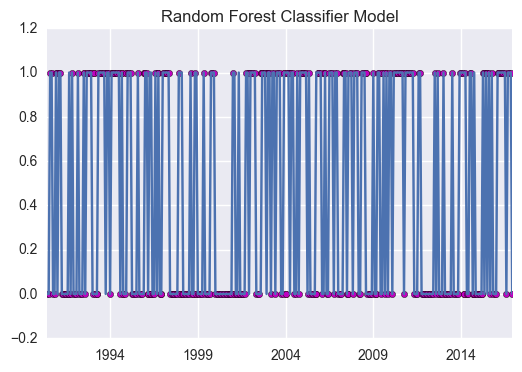

Baseline predictor: 0.47648902821316613
Random forest classifier model score (pre-GridSearch): 0.9090909090909091
Average cross validation score (MSE, pre-GridSearch): -0.45572763929618765


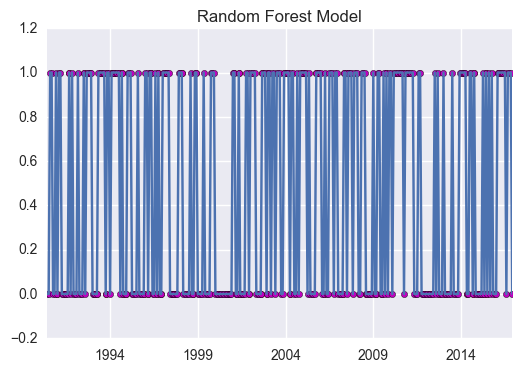

Random forest model score (with GridSearch): 1.0


In [17]:
def random_forest_classifier_with_previous_production_and_ending_stocks(dataframe, show_all_predictions = False):
    months_offset = 5
    X = dataframe.drop("ICO Composite Indicator", axis = 1).iloc[0:-months_offset]
    y = dataframe.ix[months_offset:, "ICO Composite Indicator"]
    
    y_increase = y.to_frame().pct_change() > 0
    y_increase.columns = ["Positive percent change"]
    y_increase = y_increase["Positive percent change"].map({True: 1, False: 0})
    
    train_X, test_X, train_y, test_y = train_test_split(X, y_increase)

    random_forest_classifier = RandomForestClassifier(n_estimators = 200, oob_score = True)
    random_forest_classifier.fit(train_X, train_y)

    y_increase.plot()
    plt.scatter(x = test_y.index, y = random_forest_classifier.predict(test_X), c = "r")
    if show_all_predictions == True:
        plt.scatter(x = y_increase.index, y = random_forest_classifier.predict(X), c = 'm')
    plt.title("Random Forest Classifier Model")
    plt.show()
    
    print("Baseline predictor: {}".format(y_increase.mean()))
    print("Random forest classifier model score (pre-GridSearch): {}".format(random_forest_classifier.score(X, y_increase)))
    print("Average cross validation score (MSE, pre-GridSearch): {}".format(- cross_val_score(random_forest_classifier, X, y_increase, cv = 10).mean()))
    
    param_grid_for_gridsearch = {"criterion": ["gini", "entropy"], 
                                 "max_features": [None, "sqrt", "log2"]}
    gridsearch = GridSearchCV(random_forest_classifier, param_grid_for_gridsearch, cv = 10)
    gridsearch.fit(X, y_increase)

    y_increase.plot()
    plt.scatter(x = test_y.index, y = gridsearch.predict(test_X), c ="r")
    if show_all_predictions == True:
        plt.scatter(x = y_increase.index, y = gridsearch.predict(X), c ="m")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score (with GridSearch): {}".format(gridsearch.score(X, y_increase)))
    
    return gridsearch.best_estimator_
        
random_forest_classifier = random_forest_classifier_with_previous_production_and_ending_stocks(test_dataframe, show_all_predictions = True)


In [18]:
print("Regression prediction for {}: {:.2f} cents per pound".format(
    test_dataframe.iloc[-1, 1:].name.strftime("%m-%d-%Y"), random_forest_regressor.predict(test_dataframe.iloc[-1, 1:].values.reshape(1,-1))[0]
    ))

print("Classification prediction for {}: {:.3f} chance of increase".format(
    test_dataframe.iloc[-1, 1:].name.strftime("%m-%d-%Y"), random_forest_classifier.predict_proba(test_dataframe.iloc[-1, 1:].values.reshape(1,-1))[0][1])
)

Regression prediction for 12-31-2016: 137.83 cents per pound
Classification prediction for 12-31-2016: 0.850 chance of increase


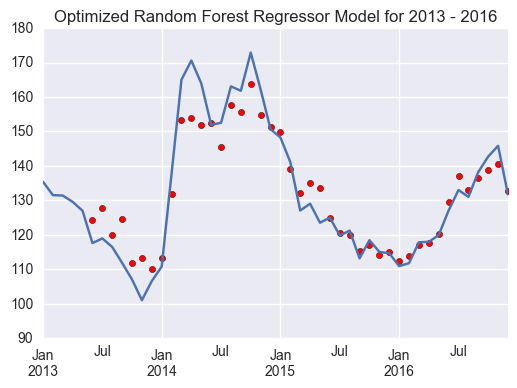

In [19]:
test_dataframe.iloc[-48:, 0].plot()
plt.scatter(x = test_dataframe.iloc[-48:, 0].index.shift(5), y = random_forest_regressor.predict(test_dataframe.iloc[-48:, 1:]), c = 'r')
plt.title("Optimized Random Forest Regressor Model for 2013 - 2016")
plt.show()


In [20]:
random_forest_classifier.predict_proba(test_dataframe.iloc[-48:, 1:])[:, 1]

array([ 0.175,  0.795,  0.2  ,  0.195,  0.265,  0.28 ,  0.78 ,  0.84 ,
        0.76 ,  0.795,  0.79 ,  0.205,  0.155,  0.735,  0.755,  0.16 ,
        0.725,  0.075,  0.065,  0.11 ,  0.16 ,  0.115,  0.785,  0.265,
        0.825,  0.295,  0.905,  0.36 ,  0.83 ,  0.075,  0.105,  0.035,
        0.905,  0.895,  0.905,  0.83 ,  0.87 ,  0.85 ,  0.31 ,  0.84 ,
        0.835,  0.755,  0.31 ,  0.61 ,  0.815,  0.84 ,  0.68 ,  0.85 ])

In [21]:
test_dataframe.shape

(324, 15)

In [22]:
print("Ratio of unique values in dataframe: {:0.3}".format(np.unique(test_dataframe.values.flatten()).shape[0] / test_dataframe.values.flatten().shape[0]))

Ratio of unique values in dataframe: 0.365


//anaconda/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


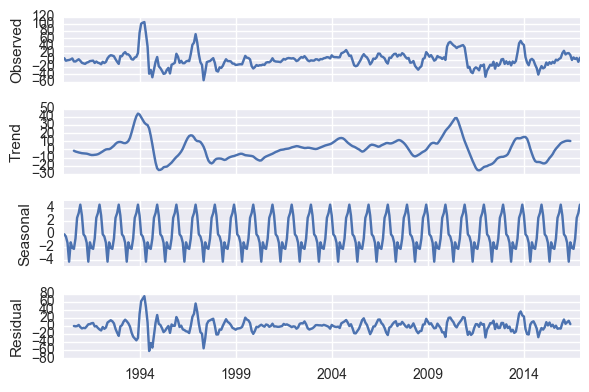

In [44]:
seasonal_decompose((random_forest_regressor.predict(test_dataframe.iloc[:, 1:]) - test_dataframe.iloc[:, 0]).dropna()).plot()
plt.show()
